In [1]:
#@Imports
import sys
import os
path = os.path.abspath('.')
if path not in sys.path:
  sys.path.insert(0, path)

from ollama_model import OllamaLanguageModel
import numpy as np
from retry import retry
import matplotlib.pyplot as plt

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3", system_message=system_message
)

@retry(ValueError, tries=5)
def compute_desire_for_gamble(model, object):
  """compute value."""
  request = (
      f"You are very logical and rational when doing this task"
      f"You are presented with a gamble. it has a probability of winning, a value of winning, and a value of losing. "
      f"If you win, you get the win value, if you lose, you get loss value. "
      f"The probability of winning is the 'win_probability']. "
      f"You need to think about an option, and how desirable it is. "
      f"Compute the expected value of the gamble first. "
      f"Think about how good or bad it is and provide a affective feeling preference value between -1 and 1 "
      f"which corresponds to the desirability of the option. "
      f"Use -1 for very bad, 0 for neutral, and 1 for very good. "
      f"The option is: {object}"
      f"Provide this answer in the form of a number between -1 and 1. "
      f"Provide only a single number as the response."
      f"Do not provide any explanations, just provide a single number."
  )

  output = model.sample_text(
    request
  )
  return float(output)

In [3]:
evs = []
choices = []
for i in range(500):

    # Simulate decision making for each player.

    Good_value = np.random.choice(np.arange(10))
    Bad_value = np.random.choice(np.arange(10))
    P_w = np.random.choice(np.arange(10) / 10)

    # Compute the expected value of the gamble.
    expected_value = P_w * Good_value + (1 - P_w) * -1*Bad_value
    Gamble_input = f"Probability of Winning (P_w): {P_w}, Positive Value on Win (G): {Good_value}, Negative Value on Loss (B): {-Bad_value}"
    #Gamble_input = f"it seems to have a monetary value of {expected_value}."

    llm_value = compute_desire_for_gamble(model, Gamble_input)

    evs.append(expected_value)
    choices.append(llm_value)

/Users/rgelpi/.pyenv/versions/3.11.8/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Text(0.5, 1.0, 'r = 0.74')

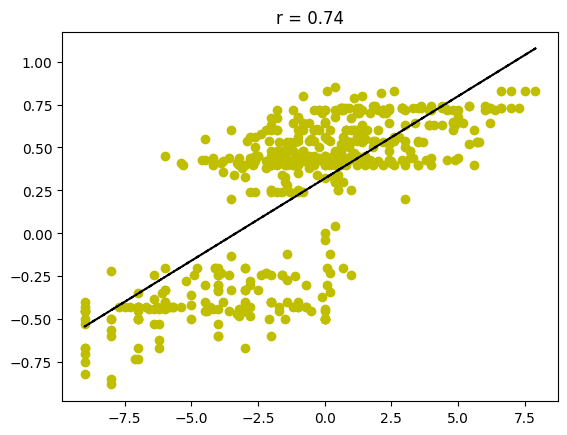

In [4]:
coef = np.polyfit(evs, choices,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y


cor = round(np.corrcoef(evs, choices)[0, 1], 2)
plt.plot(evs, choices, 'yo', evs, poly1d_fn(evs), '--k')
plt.title(f"r = {cor}")